In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the Repeat-Vector model

In [2]:
# decoder input: original time series value at last time step

class RepeatVector(object):

    def __init__(self, hidden_num, inputs, optimizer=None, reverse=True,):
        # inputs is a list with length step_num.
        # each element in inputs has size (batch_num,elem_num)
        
        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
 

        self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num,use_peepholes=True)
        self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num,use_peepholes=True)

        
        
        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)
            
        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            #Repeat vector
            dec_inputs = [self.z_codes[-1] for _ in range(len(self.z_codes))]

            (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)
 
            if reverse:
                dec_outputs = dec_outputs[::-1]

            dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
            dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
            self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_
       

        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))
   
        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load KDD99 Dataset

In [3]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/KDD99/6_subsets_win/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [4]:
tf.reset_default_graph()

batch_num = 20

hidden_num = 100

step_num = 20

elem_num = sn.shape[1]

iteration = 1000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_kdd99_v1.ckpt"

In [5]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix() for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix() for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix() for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix() for i in range(t6)]


In [6]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]
#squeeze: remove [1]dim
#split: split p_input into step_num tensors along dim 1.
# so for t in tf.split(p_input, step_num, 1), t has size (batch_num,1,elem_num)
# and each element in p_inputs has shape(batch_num,elem_num), totally step_num elements


In [7]:
ae = RepeatVector(hidden_num, p_inputs)

# Training

iter 1: 0.495161
iter 2: 0.23579
iter 3: 0.165737
iter 4: 0.145535
iter 5: 0.125866
iter 6: 0.0843348
iter 7: 0.0709904
iter 8: 0.0638848
iter 9: 0.0644535
iter 10: 0.0452829
iter 11: 0.0410068
iter 12: 0.02945
iter 13: 0.0394229
iter 14: 0.0251281
iter 15: 0.0281131
iter 16: 0.0217671
iter 17: 0.0275096
iter 18: 0.0262112
iter 19: 0.0306736
iter 20: 0.0349118
iter 21: 0.0247509
iter 22: 0.0229622
iter 23: 0.0246039
iter 24: 0.0180781
iter 25: 0.0199259
iter 26: 0.0151919
iter 27: 0.0166923
iter 28: 0.0129384
iter 29: 0.0103138
iter 30: 0.00958743
iter 31: 0.0154076
iter 32: 0.0178789
iter 33: 0.021321
iter 34: 0.0129831
iter 35: 0.0143012
iter 36: 0.0102825
iter 37: 0.0109244
iter 38: 0.013397
iter 39: 0.0102816
iter 40: 0.0130648
iter 41: 0.00909118
iter 42: 0.0111726
iter 43: 0.0134723
iter 44: 0.0135475
iter 45: 0.0110629
iter 46: 0.00894451
iter 47: 0.0111847
iter 48: 0.0101038
iter 49: 0.0114342
iter 50: 0.00966329
iter 51: 0.0115137
iter 52: 0.00634546
iter 53: 0.0106471
iter 54

iter 403: 0.00492919
iter 404: 0.00602621
iter 405: 0.00293232
iter 406: 0.00376593
iter 407: 0.00721932
iter 408: 0.00536852
iter 409: 0.00364202
iter 410: 0.00511798
iter 411: 0.00636146
iter 412: 0.00461383
iter 413: 0.00470645
iter 414: 0.00364617
iter 415: 0.00292098
iter 416: 0.00391278
iter 417: 0.00620062
iter 418: 0.00641357
iter 419: 0.00239759
iter 420: 0.0054459
iter 421: 0.00453995
iter 422: 0.0100396
iter 423: 0.00662399
iter 424: 0.00757539
iter 425: 0.00781785
iter 426: 0.00532889
iter 427: 0.004249
iter 428: 0.00651409
iter 429: 0.00337305
iter 430: 0.00332655
iter 431: 0.00611185
iter 432: 0.00595372
iter 433: 0.00441939
iter 434: 0.0057001
iter 435: 0.0036201
iter 436: 0.00340226
iter 437: 0.00465203
iter 438: 0.00487344
iter 439: 0.00572204
iter 440: 0.00620569
iter 441: 0.00551276
iter 442: 0.00557057
iter 443: 0.00652571
iter 444: 0.00787118
iter 445: 0.00366109
iter 446: 0.00439338
iter 447: 0.00634345
iter 448: 0.00619065
iter 449: 0.00322098
iter 450: 0.0077744

iter 798: 0.00693375
iter 799: 0.00478789
iter 800: 0.00465912
iter 801: 0.00572813
iter 802: 0.0041274
iter 803: 0.00597936
iter 804: 0.00366914
iter 805: 0.00615428
iter 806: 0.00438969
iter 807: 0.00447384
iter 808: 0.00330887
iter 809: 0.00586841
iter 810: 0.00280462
iter 811: 0.00360515
iter 812: 0.00395732
iter 813: 0.00361238
iter 814: 0.00471495
iter 815: 0.00400045
iter 816: 0.00412861
iter 817: 0.00288865
iter 818: 0.00341247
iter 819: 0.0045264
iter 820: 0.0030645
iter 821: 0.00376708
iter 822: 0.00687264
iter 823: 0.00536841
iter 824: 0.00270781
iter 825: 0.00333842
iter 826: 0.00425035
iter 827: 0.00272242
iter 828: 0.00422857
iter 829: 0.00391065
iter 830: 0.00324082
iter 831: 0.00435432
iter 832: 0.00357106
iter 833: 0.00510392
iter 834: 0.00342335
iter 835: 0.0053787
iter 836: 0.0066371
iter 837: 0.00381427
iter 838: 0.00427323
iter 839: 0.00730824
iter 840: 0.00470095
iter 841: 0.00806311
iter 842: 0.00509886
iter 843: 0.00551866
iter 844: 0.00401435
iter 845: 0.003409

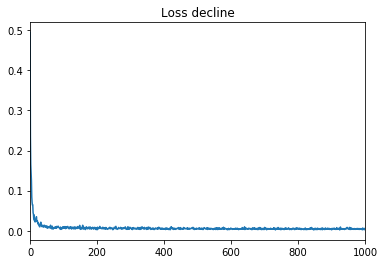

In [8]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [9]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    err_vec_list = []
    for _ in range(len(vn1_list)//batch_num):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(vn1_list)-1)
            sub = vn1_list[ind]
            data.append(sub)
        data = np.array(data)
        (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})
        err_vec_list.append(abs(input_ - output_))
    err_vec = np.mean(np.array(err_vec_list),axis=0).reshape(batch_num,-1)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_kdd99_v1.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_kdd99_v1.ckpt
Model restored.
Initialized
Finished


In [11]:
# the threshold leads to best f1 sore
def evaluate(threshold):
    beta = 0.5
    tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
    fp = len(abnormal_score)-tp
    fn = np.array(normal_score)[np.array(normal_score)>threshold].size
    tn = len(normal_score)- fn
    P = tp/(tp+fp)
    R = tp/(tp+fn)
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    return fbeta


upper = np.median(np.array(abnormal_score))
lower = np.median(np.array(normal_score)) 
scala = 20
delta = (upper-lower) / scala
candidate = lower
threshold = 0
result = 0

for _ in range(scala):
    r = evaluate(candidate)
    if r > result:
        result = r 
        threshold = candidate
    candidate += delta 

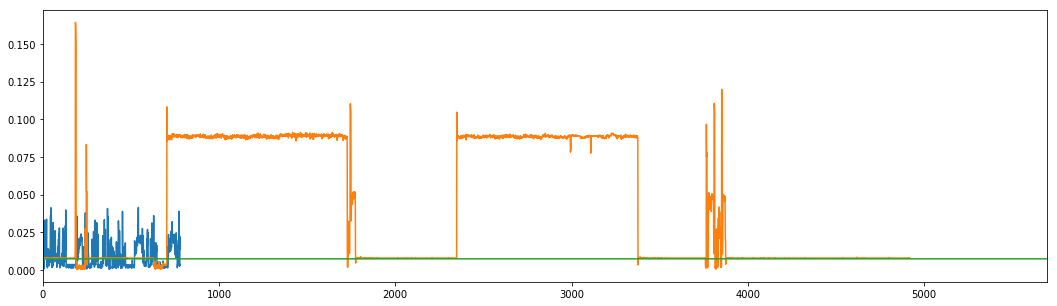

In [12]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()
bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
pd.Series(bar).plot(label="threshold")

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_kdd99_v1.ckpt
Model restored.
Initialized
Predict result :


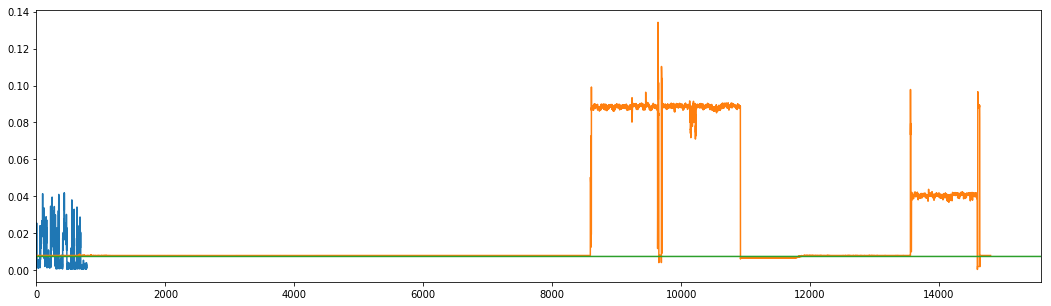

In [13]:
with tf.Session() as sess:
    saver.restore(sess, modlepath)  # decode_without_input=True, iter=5000
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)
    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [16]:
beta = 0.5
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9454300012272114

In [15]:
print(tp,fp,tn,fn,P,R)

13867 933 510 270 0.9369594594594595 0.980901181297305


In [18]:
tp/fp

14.862808145766346